In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [6]:
def findFiles(path):
    return glob.glob(path)

In [16]:
print(findFiles('data/data/names/*.txt'))

['data/data/names\\Arabic.txt', 'data/data/names\\Chinese.txt', 'data/data/names\\Czech.txt', 'data/data/names\\Dutch.txt', 'data/data/names\\English.txt', 'data/data/names\\French.txt', 'data/data/names\\German.txt', 'data/data/names\\Greek.txt', 'data/data/names\\Irish.txt', 'data/data/names\\Italian.txt', 'data/data/names\\Japanese.txt', 'data/data/names\\Korean.txt', 'data/data/names\\Polish.txt', 'data/data/names\\Portuguese.txt', 'data/data/names\\Russian.txt', 'data/data/names\\Scottish.txt', 'data/data/names\\Spanish.txt', 'data/data/names\\Vietnamese.txt']


In [17]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [18]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [19]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [20]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [21]:
category_lines = {}
all_categories = []

In [22]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [23]:
n_categories = len(all_categories)

In [24]:
print(category_lines['Italian'][:5])

KeyError: 'Italian'

In [12]:
category_lines_val = {}

for i in range(len(all_categories)):
    lst = category_lines[all_categories[i]]
    train_size = int(len(lst) * 0.8)
    random.shuffle(lst)
    lst_train = lst[:train_size]
    lst_val = lst[train_size:]
    
    category_lines[all_categories[i]] = lst_train
    category_lines_val[all_categories[i]] = lst_val

In [13]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [14]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [15]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [17]:
inp = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

with torch.no_grad():
    output, next_hidden = rnn(inp, hidden)

In [18]:
output.shape, next_hidden.shape

(torch.Size([1, 18]), torch.Size([1, 128]))

In [19]:
inp = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

with torch.no_grad():
    output, next_hidden = rnn(inp[0], hidden)

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 16)


In [21]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValidationExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [22]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Ibanez
category = Scottish / line = Thomson
category = Russian / line = Ageenko
category = Polish / line = Krol
category = Chinese / line = Lim
category = Polish / line = Sokolsky
category = Italian / line = Ronchi
category = Polish / line = Kaminski
category = French / line = Sarkozi
category = Chinese / line = Rong


In [23]:
criterion = nn.NLLLoss()

In [24]:
optimizer = torch.optim.SGD(rnn.parameters(), lr=5e-3)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

def evaluate(line_tensor):
    with torch.no_grad():
        hidden = rnn.initHidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

    return output

In [25]:
n_iters = 500_000
print_every = 5000
val_size = 3000

In [26]:
current_loss = 0
all_losses = []
all_precisions = []
best_value = 0
best_model = None

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        with torch.no_grad():
            num_correct = 0
            for _ in range(val_size):
                category, line, category_tensor, line_tensor = randomValidationExample()
                output = evaluate(line_tensor)
                guess, guess_i = categoryFromOutput(output)
                category_i = all_categories.index(category)
                num_correct += (guess_i == category_i)
            prec = num_correct / val_size
            all_precisions.append(prec)
            
            if prec > best_value:
                best_value = prec
                best_model = rnn.state_dict().copy()
            
        all_losses.append(current_loss / print_every)
        
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %f, %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), current_loss, prec, line, guess, correct))
        current_loss = 0

  0%|          | 0/500000 [00:00<?, ?it/s]

5000 1% (0m 4s) 13738.738703, 0.2760 Fattore / French ✗ (Italian)
10000 2% (0m 8s) 11571.993194, 0.2600 Sauvageon / Dutch ✗ (French)
15000 3% (0m 13s) 10410.892354, 0.3087 Ooka / Japanese ✓
20000 4% (0m 17s) 9606.127254, 0.3750 Southern / Dutch ✗ (English)
25000 5% (0m 21s) 8947.190839, 0.4050 Chaadaev / Russian ✓
30000 6% (0m 25s) 8524.050269, 0.3950 Yeatman / Irish ✗ (English)
35000 7% (0m 30s) 8213.615800, 0.4127 Handzlik / Russian ✗ (Czech)
40000 8% (0m 34s) 7822.176346, 0.4203 Acconci / Italian ✓
45000 9% (0m 38s) 7388.272696, 0.4380 Lynsmeier / French ✗ (Czech)
50000 10% (0m 43s) 7369.104327, 0.4447 Rhys / Korean ✗ (Irish)
55000 11% (0m 47s) 7066.060282, 0.4113 Millar / Scottish ✓
60000 12% (0m 51s) 7000.859408, 0.4533 Rey / English ✗ (Spanish)
65000 13% (0m 56s) 6906.014759, 0.4313 Phan / Irish ✗ (Vietnamese)
70000 14% (1m 0s) 6778.263427, 0.4507 Segher / German ✗ (Dutch)
75000 15% (1m 4s) 6645.339438, 0.4537 Akram / Arabic ✗ (English)
80000 16% (1m 9s) 6462.847527, 0.4277 Rey /

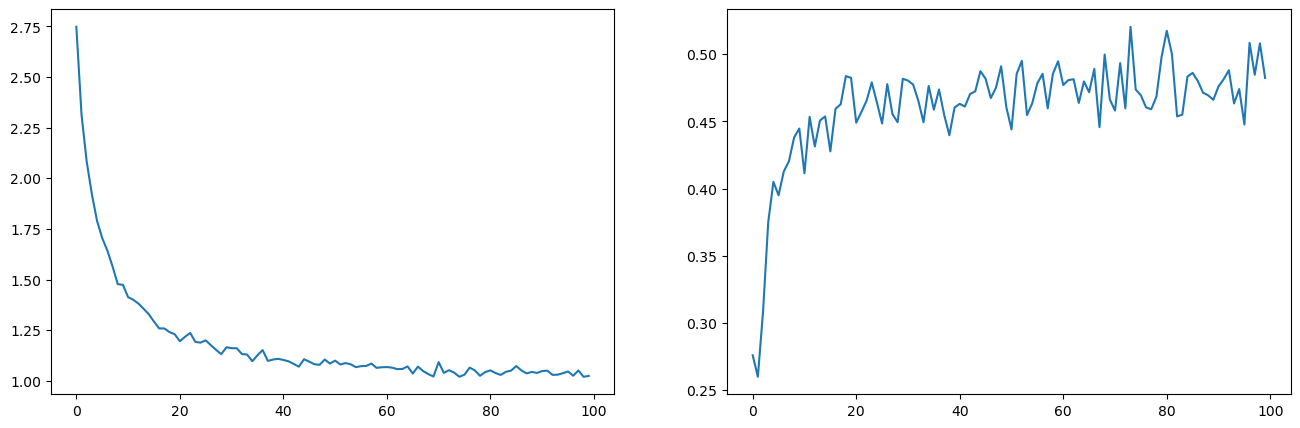

In [27]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(all_losses)

plt.subplot(1, 2, 2)
plt.plot(all_precisions)

In [28]:
rnn.load_state_dict(best_model)

<All keys matched successfully>

/tmp/ipykernel_90184/3249864722.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_90184/3249864722.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


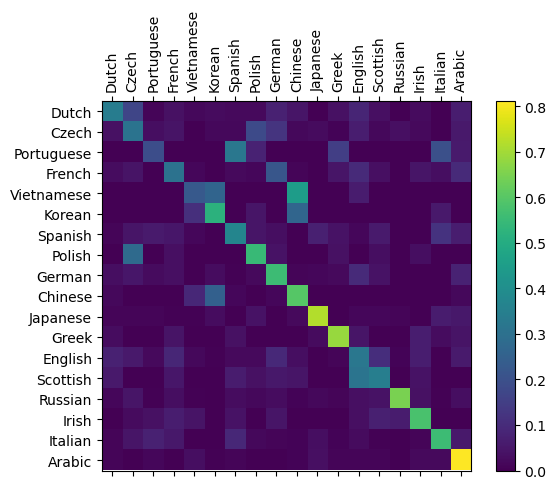

In [29]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomValidationExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [30]:
def predict(input_line, n_predictions=3):
    print('> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [31]:
predict('Dovesky')

> Dovesky
(-0.37) Czech
(-1.26) Russian
(-4.26) English


In [32]:
predict('Jackson')

> Jackson
(-0.96) Scottish
(-1.26) French
(-1.52) English


In [33]:
predict('Satoshi')

> Satoshi
(-0.69) Japanese
(-1.40) Arabic
(-1.98) Italian
